# Detecting AI Generated Text
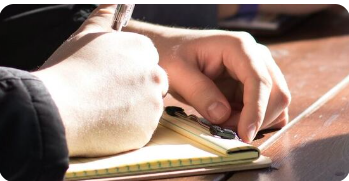

In [2]:
# Importing Libraries
import pandas as pd #to handle csv as dataframes
import numpy as np #to perform vector computations
import seaborn as sns #Data Visualisation
import matplotlib.pyplot as plt #Data Visualisation

In [3]:
df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of prompt ID')

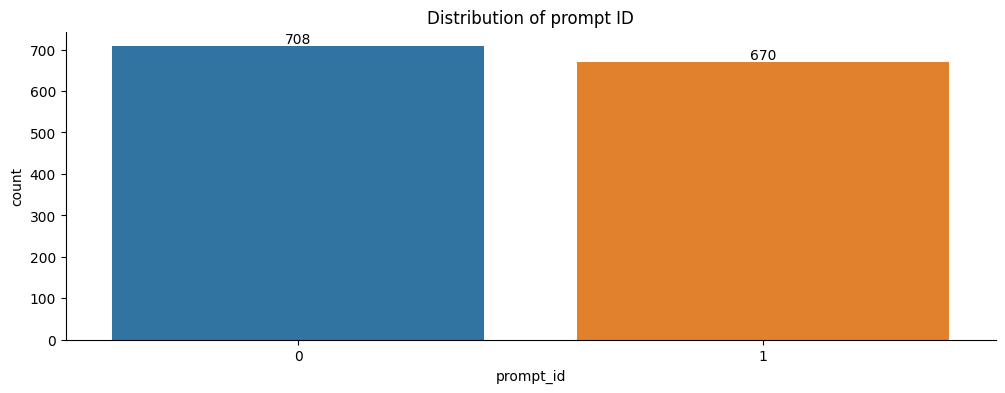

In [24]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df,
                   x="prompt_id")

abs_values = df['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")


Text(0.5, 1.0, 'Distribution of Generated Text')

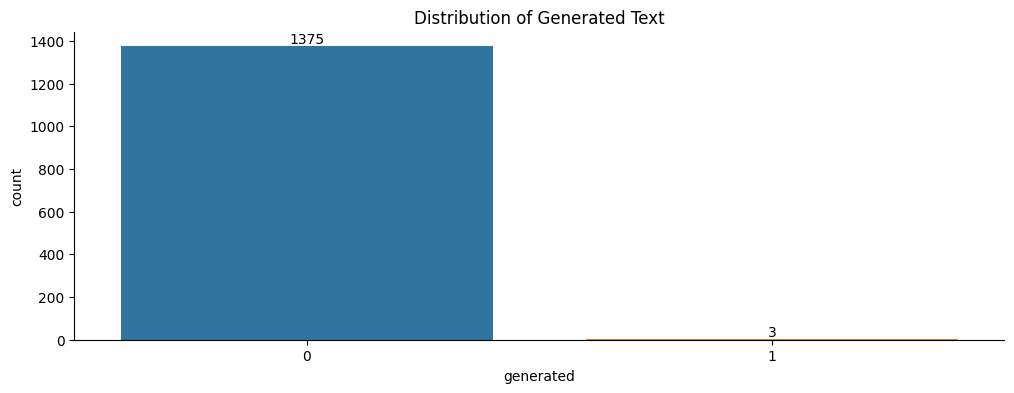

In [25]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df,
                   x="generated")

abs_values = df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

#### Inferences:
    1. 1375 essays are written by human and only 3 by AI.
    2. The distribution between the two prompts is pretty equal.
    3. Add new data to the training dataset.As the dataset does not contain any generated data. We will use the dataset created by DAREK KŁECZEK

In [4]:
df_gen = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
print(df_gen.info())
df_gen.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB
None


,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

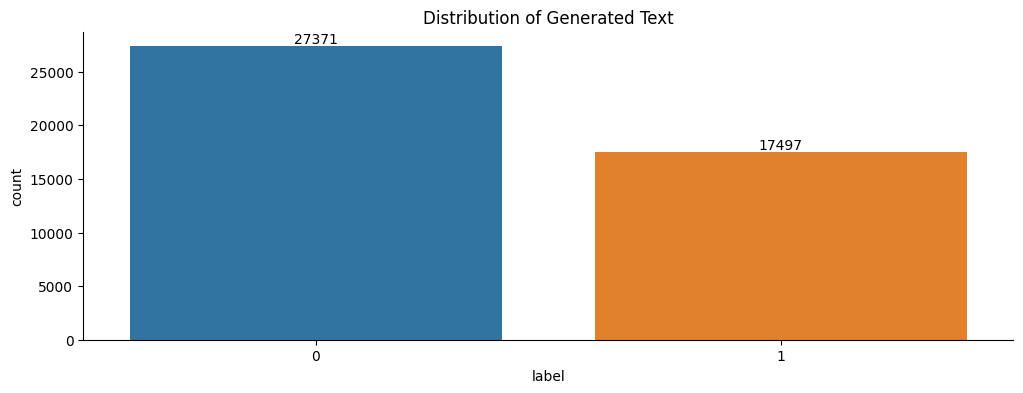

In [27]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_gen,
                   x="label")

abs_values = df_gen['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [5]:
df_new = pd.DataFrame({'text':list(df["text"].values)+list(df_gen['text'].values),'label':list(df['generated'].values)+list(df_gen['label'].values)})
df_new.head()

,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46246 entries, 0 to 46245
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    46246 non-null  object
 1   label   46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 722.7+ KB


#### Label: 0->Human 1->LLM Generated

### Preparing Dataset

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 4000x5000 with 0 Axes>

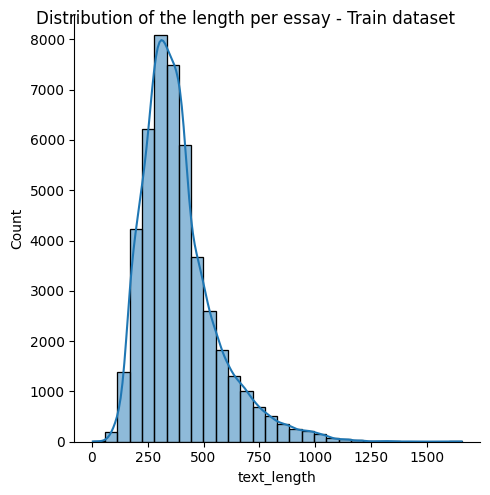

In [29]:
df_new["text_length"] = df_new["text"].apply(lambda x : len(x.split()))
fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=df_new,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")

In [30]:
df_new["text_length"].mean() + df_new["text_length"].std()

556.1289768295229

In [37]:
!pip install catboost

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [34]:
from sklearn.linear_model import LogisticRegression

In [47]:
def text_classification(train_sentences, train_labels):
    
    # Vectorize the text data using CountVectorizer
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_sentences)
    
    X_test = vectorizer.transform(["Cars. Cars have been around since they became"])
    
    # Split the data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, train_labels, test_size=0.3, random_state=42)

    # Naive Bayes Classifier
    nb_classifier = LogisticRegression()
    nb_classifier.fit(X_train, train_labels)

    #print(nb_classifier.predict(X_test))
    
    
    # Evaluate and print metrics for Naive Bayes
    nb_predictions = nb_classifier.predict(X_val_split)
    nb_accuracy = accuracy_score(y_val_split, nb_predictions)
    nb_report = classification_report(y_val_split, nb_predictions)

    print("Naive Bayes Classifier Performance:")
    print(f"Accuracy: {nb_accuracy:.4f}")
    #print("Classification Report:")
    #print(nb_report)
    
    pickle.dump(vectorizer, open("vector.pickel", "wb"))
    
    with open('logreg_model.pkl','wb') as f:
        pickle.dump(nb_classifier,f)



# Example usage:
train_sentences = list(df_new['text'].values)
train_labels = list(df_new['label'].values)

text_classification(train_sentences, train_labels)

Naive Bayes Classifier Performance:
Accuracy: 1.0000


<table>
  <tr>
    <th>Model</th>
    <th>Accuracy</th>
  </tr>
    <tr>
    <td>LogisticRegression</td>
    <td>0.9926</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.9777</td>
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>0.9634</td>
  </tr>
    <tr>
    <td>Catboost</td>
    <td>0.9903</td>
  </tr>
    <tr>
    <td>XGBoost</td>
    <td>0.9911</td>
  </tr>
</table>